<a href="https://colab.research.google.com/github/iammtaran21/tf1/blob/main/I_Sarcasm_detect_Transformers_Final_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import gc
from tqdm.autonotebook import tqdm

from sklearn.metrics import accuracy_score,f1_score

import sklearn

import torch
from simpletransformers.classification import ClassificationModel

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-a35c0700917c>:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
train_data = pd.read_csv("/content/I-Sarcasm_train_.csv")
test_data = pd.read_csv("/content/I-Sarcasm_test_.csv")

In [51]:
train_analysis = pd.read_csv("/content/I-Sarcasm_train_.csv",usecols=["tweet", "sarcasm_label"])
# questions.columns = ["tweet", "sarcasm_label"]


In [52]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

train_analysis = standardize_text(train_analysis, "tweet")

train_analysis.to_csv("analysis_data.csv")

In [53]:
analysis_data = pd.read_csv("analysis_data.csv")


In [54]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

analysis_data["tokens"] = analysis_data["tweet"].apply(str).apply(tokenizer.tokenize)
analysis_data.head()

,Unnamed: 0,tweet,sarcasm_label,tokens
0,0,it's been a while since i visited my grandpare...,not_sarcastic,"[it, s, been, a, while, since, i, visited, my,..."
1,1,well done monty mark that up as your first ev...,not_sarcastic,"[well, done, monty, mark, that, up, as, your, ..."
2,2,since this is fantasy can it be any individua...,not_sarcastic,"[since, this, is, fantasy, can, it, be, any, i..."
3,3,really? i don't think you know what you are ta...,not_sarcastic,"[really, i, don, t, think, you, know, what, yo..."
4,4,missed toughenough tonight? no worries just ...,sarcastic,"[missed, toughenough, tonight, no, worries, ju..."


In [55]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
all_words = [word for tokens in analysis_data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in analysis_data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

50696 words total, with a vocabulary size of 10432
Max sentence length is 41


In [56]:
train_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,992251158159765000,It's been a while since I visited my grandpare...,not_sarcastic,NaN
1,1084373658745870000,Well done Monty. Mark that up as your first ev...,not_sarcastic,NaN
2,812181186,@davesnyder since this is fantasy can it be an...,not_sarcastic,NaN
3,1090276741329920000,Really? I don't think you know what you are ta...,not_sarcastic,NaN
4,553070692682723000,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,sarcasm


In [57]:
test_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
0,933721764970057000,"Gandhis busy, Congress delays UP brainstorming...",sarcastic,sarcasm
1,1086119014131200000,George and the Ice Cream Castle - Charlie and ...,not_sarcastic,NaN
2,657671293756567000,Hartford House Delegation Scores Funding For C...,not_sarcastic,NaN
3,914242426755256000,Obama to rename tallest U.S. peak: To hear the...,not_sarcastic,NaN
4,1088604537211040000,So @elonmusk couldn’t care less I guess 🤷🏻‍♂️ ...,sarcastic,satire


In [58]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train_data.drop("tweet_id",inplace=True,axis=1)

In [59]:
train_tweets=train_data['tweet'].tolist()
test_tweets=test_data['tweet'].tolist()


In [60]:
train_data.describe().T

,count,unique,top,freq
tweet,3577,3523,LOL...Walker is talking about education...the ...,3
sarcasm_label,3577,2,not_sarcastic,2297
sarcasm_type,1279,7,sarcasm,880


In [61]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [62]:
train_data.isna().sum()

tweet               0
sarcasm_label       0
sarcasm_type     2298
dtype: int64

In [63]:
train_data.head()

,tweet,sarcasm_label,sarcasm_type
986,#Ironic He's afraid that there might not be an...,sarcastic,irony
1337,"If your not a long distance runner, you will n...",not_sarcastic,NaN
1808,@HaroldItz It's just collateral damage. A pric...,not_sarcastic,NaN
2631,@BoobsRadley if Led Zeppelin isn't your top 10...,sarcastic,sarcasm
521,#news Ruby Mills surges on bonus issue plans: ...,not_sarcastic,NaN


In [64]:
train_data["sarcasm_type"].fillna("No sarcasm",inplace=True)


In [65]:
train_data.head()

,tweet,sarcasm_label,sarcasm_type
986,#Ironic He's afraid that there might not be an...,sarcastic,irony
1337,"If your not a long distance runner, you will n...",not_sarcastic,No sarcasm
1808,@HaroldItz It's just collateral damage. A pric...,not_sarcastic,No sarcasm
2631,@BoobsRadley if Led Zeppelin isn't your top 10...,sarcastic,sarcasm
521,#news Ruby Mills surges on bonus issue plans: ...,not_sarcastic,No sarcasm


In [66]:
test_data.isna().sum()

tweet_id           0
tweet              0
sarcasm_label      0
sarcasm_type     640
dtype: int64

In [67]:
test_data["sarcasm_type"].fillna("No sarcasm",inplace=True)
test_data.head()

,tweet_id,tweet,sarcasm_label,sarcasm_type
512,1077343950963460000,Yup yup ðŸ’œ #late #night #best #conversations...,not_sarcastic,No sarcasm
29,746217395467890000,Huge Network | #Politics Hillary Clinton e-ma...,not_sarcastic,No sarcasm
119,1167364873782800000,Jeremy Corbyn Offers New Parental Rights To Se...,not_sarcastic,No sarcasm
316,1031676863566040000,I love iPhone chargers so muchðŸ˜Š #sarcastic,sarcastic,sarcasm
93,1170802893550730000,Just got arkham knight: limited edition. Thank...,sarcastic,sarcasm


In [68]:
# train_data=keep_uniques(train_tweets, train_data)
# test_data=keep_uniques(test_tweets, test_data)
train_data.drop("tweet_id",inplace=True,axis=1)

KeyError: ignored

In [ ]:
test_data.drop("tweet_id",inplace=True,axis=1)

In [69]:
train_data.sarcasm_type.replace("#news #live #breakingnews Premarket: Blood-letting eases for global stocks, but China smashed again","No sarcasm",inplace=True)

In [70]:
train_data.sarcasm_label.value_counts()

not_sarcastic    2297
sarcastic        1280
Name: sarcasm_label, dtype: int64

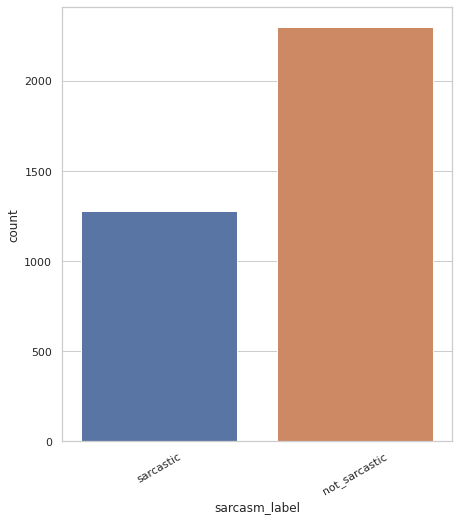

In [87]:
sns.countplot(train_data.sarcasm_label)
sns.set(rc={'figure.figsize':(7,8)})
plt.xticks(rotation=30);

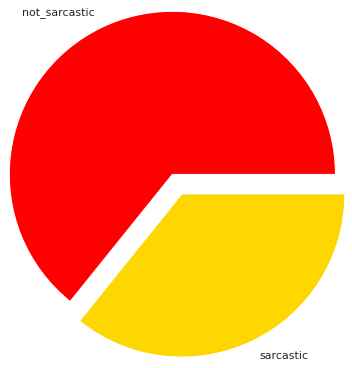

In [72]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1]
train_data.sarcasm_label.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["red", "gold", "green",'blue','purple','red']);


In [73]:
train_data.sarcasm_type.value_counts()

No sarcasm             2299
sarcasm                 880
irony                   261
overstatement            47
rhetorical question      43
satire                   39
understatement            8
Name: sarcasm_type, dtype: int64

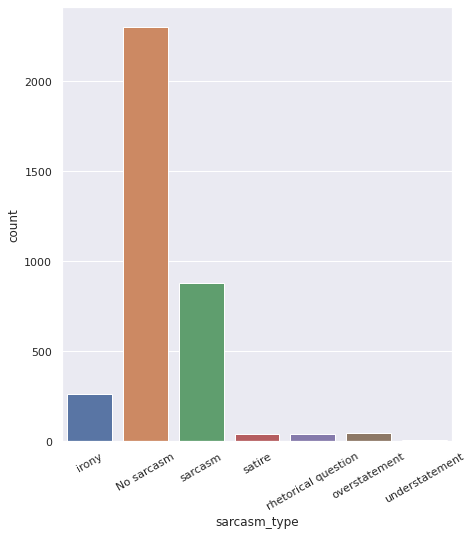

In [74]:
sns.countplot(train_data.sarcasm_type)
sns.color_palette("mako", as_cmap=True)

plt.xticks(rotation=30);

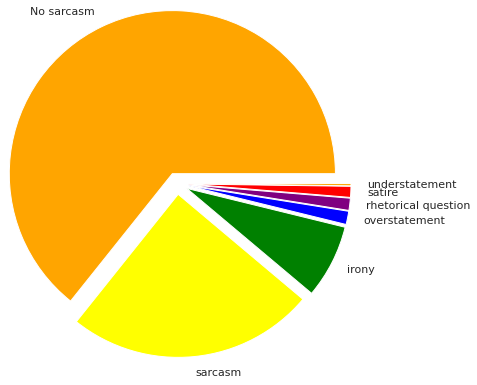

In [75]:
# pie chart using seaborn based on total count of different sentiments in training dataset 

explode = [0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1]
sns.set_theme(style="whitegrid")
train_data.sarcasm_type.value_counts().plot(kind='pie',explode=explode,figsize=(5,5),radius=1.5,colors=["orange", "yellow", "green",'blue','purple','red']);


In [76]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [77]:
tqdm.pandas() 

train_data['cleaned_text']= train_data['tweet'].progress_apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweet'].progress_apply((lambda x: clean(x)))

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/907 [00:00<?, ?it/s]

In [78]:
train_data.drop("sarcasm_type",inplace=True,axis=1)
train_data.head()

,tweet,sarcasm_label,cleaned_text
986,#Ironic He's afraid that there might not be an...,sarcastic,ironic afraid might afterlife terrified believe
1337,"If your not a long distance runner, you will n...",not_sarcastic,long distance runner never know compete euphor...
1808,@HaroldItz It's just collateral damage. A pric...,not_sarcastic,collateral damage price pay freedom oppressive...
2631,@BoobsRadley if Led Zeppelin isn't your top 10...,sarcastic,led zeppelin top 10 favourite band real fan po...
521,#news Ruby Mills surges on bonus issue plans: ...,not_sarcastic,news ruby mills surges bonus issue plans board...


In [79]:
train_data.head()

,tweet,sarcasm_label,cleaned_text
986,#Ironic He's afraid that there might not be an...,sarcastic,ironic afraid might afterlife terrified believe
1337,"If your not a long distance runner, you will n...",not_sarcastic,long distance runner never know compete euphor...
1808,@HaroldItz It's just collateral damage. A pric...,not_sarcastic,collateral damage price pay freedom oppressive...
2631,@BoobsRadley if Led Zeppelin isn't your top 10...,sarcastic,led zeppelin top 10 favourite band real fan po...
521,#news Ruby Mills surges on bonus issue plans: ...,not_sarcastic,news ruby mills surges bonus issue plans board...


In [80]:
train_data['tweet'] = train_data['tweet'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

In [81]:

train_data["tweet"] = train_data["tweet"].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]','',text,re.I|re.A))
train_data.head(10)

,tweet,sarcasm_label,cleaned_text
986,Ironic Hes afraid that there might not be an a...,sarcastic,ironic afraid might afterlife terrified believe
1337,If your not a long distance runner you will ne...,not_sarcastic,long distance runner never know compete euphor...
1808,HaroldItz Its just collateral damage A price t...,not_sarcastic,collateral damage price pay freedom oppressive...
2631,BoobsRadley if Led Zeppelin isnt your top 10 f...,sarcastic,led zeppelin top 10 favourite band real fan po...
521,news Ruby Mills surges on bonus issue plans Th...,not_sarcastic,news ruby mills surges bonus issue plans board...
525,Review of review news design tech l,not_sarcastic,review review news design tech lâ€¦
1301,Is a coherent philosophy of race possible See ...,not_sarcastic,coherent philosophy race possible see philosop...
1187,Do you think a great businessman amp a great l...,not_sarcastic,think great businessman great leader one trump...
1122,Just waking up is not cool late,not_sarcastic,waking cool ðÿ™ˆ late
1499,Pakistan News Impediment in justice delivery ...,not_sarcastic,pakistan news impediment justice delivery ihc ...


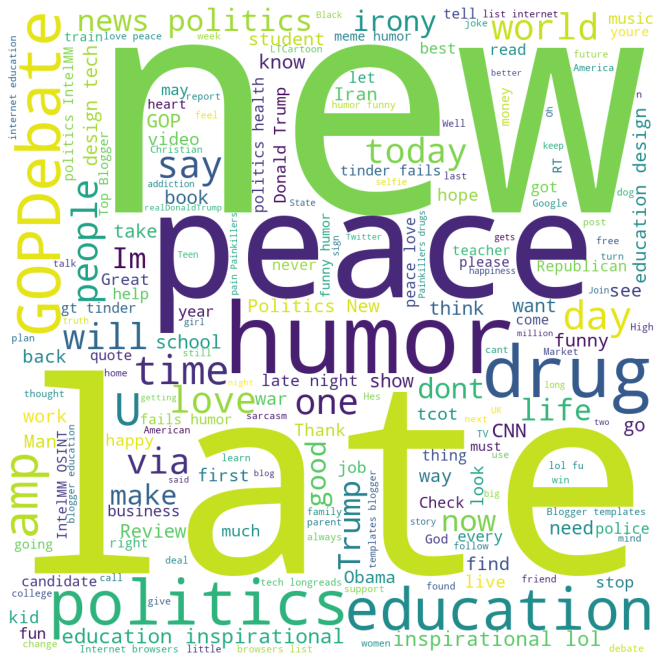

In [82]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet[train_data['sarcasm_label']=='not_sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(background_color='white',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

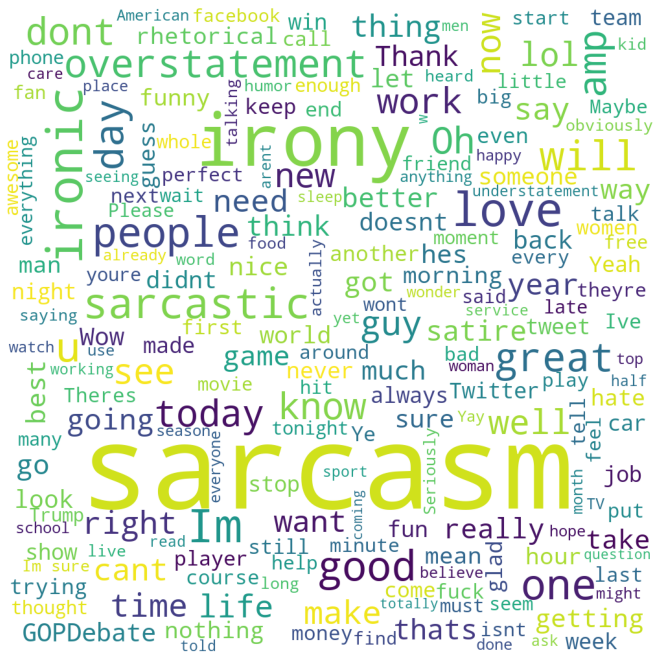

In [83]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet[train_data['sarcasm_label']=='sarcastic']:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(
                         background_color='white',stopwords=stopwords,
                         min_font_size=5,width=1000, height=1000).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

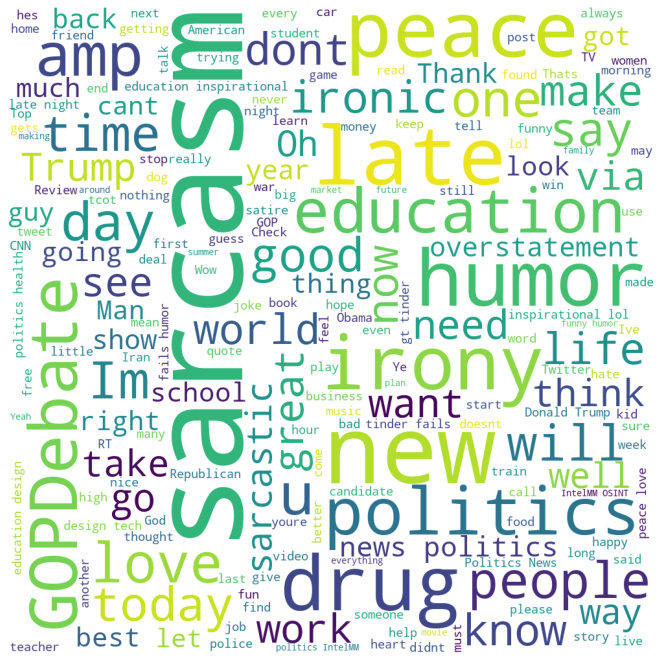

In [84]:
start_all_words=''
stopwords= set(STOPWORDS)
for word in train_data.tweet:
    start_all_words=start_all_words + word + ' '
start_wordcloud=WordCloud(width=1000,height=1000,
                         background_color='white',stopwords=stopwords,
                         min_font_size=5).generate(start_all_words)
# clean_all_words=''
# for newword in train.tweet:
#     clean_all_words= clean_all_words + newword + ' '
# clean_wordcloud=WordCloud(width=1000,height=1000,
#                          background_color='white',stopwords=stopwords,
#                          min_font_size=10).generate(clean_all_words)

plt.figure(1,figsize=(18,15))
plt.subplot(121)
plt.imshow(start_wordcloud)
# plt.subplot(122)
# plt.imshow(clean_all_words)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [85]:
# Concatenate all tweets into one string
text = " ".join(train_data['tweet'].tolist())

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Access the words_ attribute to get the frequencies of the words
word_frequencies = wordcloud.words_

# Sort the dictionary by frequency to get the most frequent words
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words:")
for word, frequency in sorted_words[:10]:
    print(f"{word}: {frequency}")

Most frequent words:
sarcasm: 1.0
new: 0.47218934911242605
late: 0.3289940828402367
peace: 0.30414201183431955
humor: 0.3029585798816568
drug: 0.2875739644970414
irony: 0.27928994082840236
GOPDebate: 0.21420118343195266
politics: 0.20946745562130178
education: 0.1834319526627219


In [86]:
sarcastic_text = " ".join(train_data[train_data['sarcasm_label'] == 'sarcastic']['tweet'].tolist())
non_sarcastic_text = " ".join(train_data[train_data['sarcasm_label'] == 'not_sarcastic']['tweet'].tolist())

sarcastic_wordcloud = WordCloud().generate(sarcastic_text)
non_sarcastic_wordcloud = WordCloud().generate(non_sarcastic_text)

sarcastic_word_frequencies = sarcastic_wordcloud.words_
non_sarcastic_word_frequencies = non_sarcastic_wordcloud.words_

sorted_sarcastic_words = sorted(sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)
sorted_non_sarcastic_words = sorted(non_sarcastic_word_frequencies.items(), key=lambda x: x[1], reverse=True)

print("Most frequent sarcastic words:")
for word, frequency in sorted_sarcastic_words[:10]:
    print(f"{word}: {frequency}")

print("\nMost frequent non-sarcastic words:")
for word, frequency in sorted_non_sarcastic_words[:10]:
    print(f"{word}: {frequency}")


Most frequent sarcastic words:
sarcasm: 1.0
irony: 0.24213075060532688
ironic: 0.08716707021791767
Im: 0.07869249394673124
love: 0.07869249394673124
one: 0.06295399515738499
sarcastic: 0.06295399515738499
good: 0.06174334140435835
u: 0.06174334140435835
people: 0.06174334140435835

Most frequent non-sarcastic words:
new: 1.0
late: 0.736986301369863
peace: 0.7095890410958904
humor: 0.6986301369863014
drug: 0.6520547945205479
politics: 0.4821917808219178
GOPDebate: 0.4520547945205479
education: 0.4328767123287671
amp: 0.29863013698630136
U: 0.24383561643835616


In [ ]:
train_data

,tweet,sarcasm_label,cleaned_text
0,It's been a while since I visited my grandpare...,not_sarcastic,since visited grandparentswait
1,Well done Monty. Mark that up as your first ev...,not_sarcastic,well done monty mark first ever 100 honest acc...
2,@davesnyder since this is fantasy can it be an...,not_sarcastic,since fantasy individual time alive today
3,Really? I don't think you know what you are ta...,not_sarcastic,really think know talking please provide evide...
4,Missed #ToughEnough tonight? No worries. Just ...,sarcastic,missed toughenough tonight worries watch episo...
...,...,...,...
3572,"Hey Christine Nixon, people like @johannhari10...",not_sarcastic,hey christine nixon people like cover every si...
3573,#Erythropoietin #Drugs market to reach $11.9 b...,not_sarcastic,erythropoietin drugs market reach 119 billion ...
3574,Apple's first Android app wants you to stop us...,sarcastic,apples first android app wants stop using andr...
3575,Hurry! Ending soon! Follow b4 16.09.15 4chance...,not_sarcastic,hurry ending soon follow b4 160915 4chance2win...


In [20]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'not_sarcastic':0,
        'sarcastic':1
    }
    return class_dict[t_class]

In [21]:
train_data["target"] = train_data['sarcasm_label'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['sarcasm_label'].apply(lambda x: encode_target(x))

In [22]:
train = train_data[['tweet','target']]
train.columns = ['text','labels']

test = test_data[['tweet','target']]
test.columns = ['text','labels']

In [23]:
train.head()

,text,labels
3183,Google ranks http://t.co/Gpl5Dxu7f6 @LTCartoon...,0
2380,I guess my takeaway this morning is that #Sand...,1
2783,Drawing is a life style ;) #drawing #Peace #to...,0
3035,How #NorthKoreans shoot #guns #NorthKorea #NK ...,0
2363,Oh no... #DowntonAbbey is ending?... Dang... N...,1


In [24]:
test.head()

,text,labels
522,"#peace #healing #friendship, enjoy! Please #re...",0
576,"I know it sounds crazy, but I suspect the drug...",1
477,http://t.co/5MHOz41KlV Would you help baby rub...,0
623,"Huge Network | #Politics O'Malley, Wasserman ...",0
407,Ortiz mashes 2 homers to reach 500 for career:...,0


In [ ]:
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     # args=train_args
# )

In [ ]:
# !pip install transformers
# import transformers

# model_type = 'distilbert'
# model_name = 'distilbert-base-cased'
# model = transformers.pipeline("text-classification", model=model_name, tokenizer=model_name)


In [25]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score


In [26]:
model_type = 'distilbert'
model_name = 'distilbert-base-uncased'
seed = 100
model_args =  {'fp16': False,
               'train_batch_size': 128,
               'gradient_accumulation_steps': 2,
#                'do_lower_case': True,
               'learning_rate': 1e-4,
               'overwrite_output_dir': True,
               'manual_seed': seed,
               'num_train_epochs': 6}


In [27]:
model = ClassificationModel(model_type, model_name,num_labels=4,args=model_args,use_cuda=False) 
# model = ClassificationModel(
#     "bert", "dbmdz/bert-base-turkish-cased",
#     num_labels=4,
#     args=train_args
# ) 
#args=model_args


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [28]:
model.train_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/28 [00:00<?, ?it/s]

(84, 0.27926461429645616)

In [29]:
result_train, model_outputs_train, wrong_predictions_train = model.eval_model(train,acc=accuracy_score)

  0%|          | 0/3577 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/448 [00:00<?, ?it/s]

In [30]:
print("TRAIN SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result_train['acc']*100))
print("%s: %.5f" % ('Final Loss', result_train['eval_loss']))

TRAIN SET EVALUATION:
Accuracy: 97.34%
Final Loss: 0.08771


In [31]:
result, model_outputs, wrong_predictions = model.eval_model(test,acc=accuracy_score)

  0%|          | 0/907 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/114 [00:00<?, ?it/s]

In [32]:
print("TEST SET EVALUATION:")
print("====================================")
print("%s: %.2f%%" % ('Accuracy', result['acc']*100))
print("%s: %.5f" % ('Final Loss', result['eval_loss']))

TEST SET EVALUATION:
Accuracy: 93.50%
Final Loss: 0.18640


In [33]:
test.shape

(907, 2)

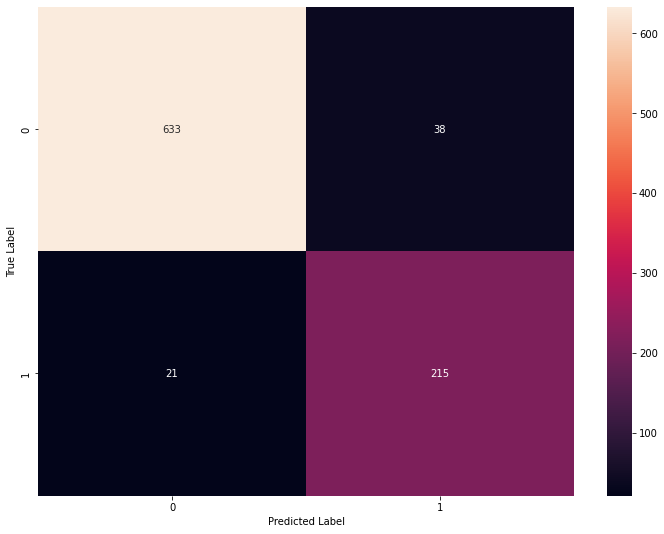

In [48]:
from sklearn.metrics import confusion_matrix



confusion_matrix = confusion_matrix(test.labels, model_outputs)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.gcf().set_size_inches(12,9)

plt.show()

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics

In [35]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [36]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

In [37]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [38]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

In [39]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

In [40]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 79.9425% 
-> WordLevel TF-IDF Accuracy: 78.4001%
